In [1]:
import os
import sys
sys.path.append("../../../..")
from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import get_model_rocs, allign_metrics, report_alligned_metrics
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict, plot_losses
from nebula.models.attention import TransformerEncoderChunks
from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, *[".."]*4)
import numpy as np
import pickle
RUN_TYPES = ["None", "0.1", "0.5", "1"]
RUN_NAME = "gradient clipping values"

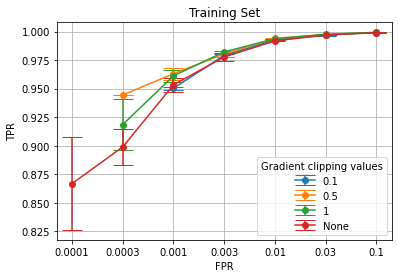

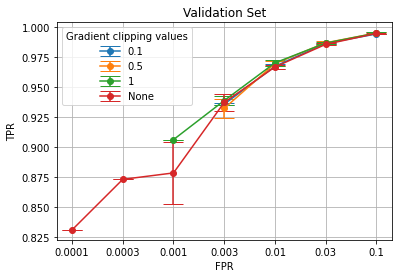

In [2]:
folder = "."
training_files = [x for x in os.listdir(folder) if x.endswith("training.json")]
validation_files = [x for x in os.listdir(folder) if x.endswith("validation.json")]

def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[2]

metrics_train = read_cv_metrics_folder('.', key_extractor, training_filter)
metrics_val = read_cv_metrics_folder('.', key_extractor, validation_filter)

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [3]:
model_config = {
    "vocab_size": 50002,
    "maxlen": 512,
    "chunk_size": 64,
    "dModel": 64,
    "nHeads": 8,
    "dHidden": 256,
    "nLayers": 2,
    "numClasses": 1,
    "hiddenNeurons": [
        64
    ],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False
}

data_splits = read_cv_data_splits("../learning_rates_limit_None_1677580013/")

existing_pickle = os.path.join(folder, "roc_metrics_val.pkl")
if os.path.exists(existing_pickle):
    roc_metrics_val = pickle.load(open(existing_pickle, "rb"))
else:
    roc_metrics_val = get_model_rocs(
        run_types=RUN_TYPES,
        model_class=TransformerEncoderChunks,
        model_config=model_config,
        data_splits=data_splits,
    )
    pickle.dump(roc_metrics_val, open(existing_pickle, "wb"))

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(roc_metrics_val)

,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC
None,0.576778,0.747533,0.856165,0.935384,0.966493,0.985442,0.995005,0.999009,0.997610
0.1,0.561417,0.742560,0.856791,0.931157,0.967155,0.986803,0.994519,0.998795,0.997608
0.5,0.450427,0.690071,0.880540,0.936638,0.968786,0.987347,0.995180,0.998892,0.997718
1,0.524324,0.652609,0.880148,0.936817,0.970672,0.986754,0.995219,0.998873,0.997737


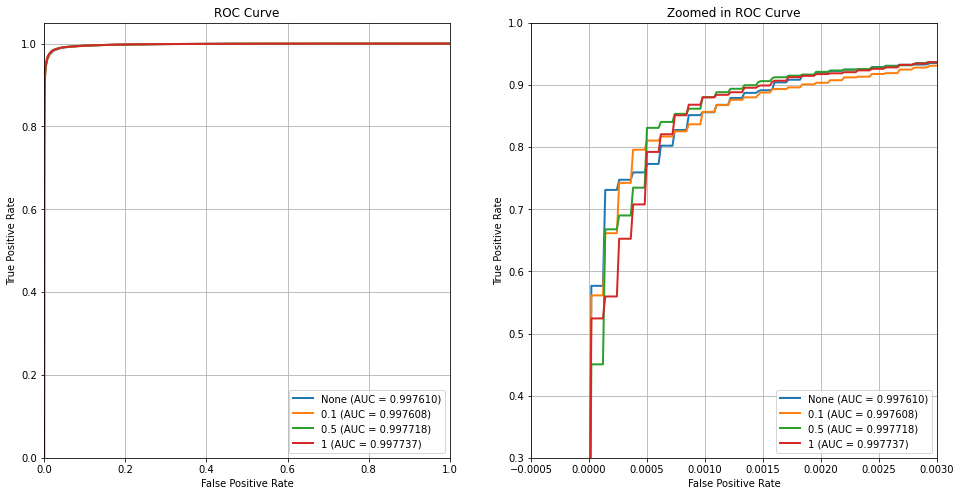

In [4]:
df, axs_val = report_alligned_metrics(base_fpr_val, tprs_mean_val, None, roc_metrics_val, xlim=[-0.0005, 0.003], ylim=[0.3, 1.0])
df

## Test set ROCs

In [5]:
xtestpath = os.path.join(REPO_ROOT, r"data\data_filtered\speakeasy_testset_BPE_50k\speakeasy_vocab_size_50000_maxlen_512_x.npy")
X_test = np.load(xtestpath)
ytestpath = os.path.join(REPO_ROOT, r"data\data_filtered\speakeasy_testset_BPE_50k\speakeasy_y.npy")
y_test = np.load(ytestpath)

splits = 3
data_splits = [{"X_test": X_test, "y_test": y_test}]*splits

existing_pickle = os.path.join(folder, "roc_metrics_test.pkl")
if os.path.exists(existing_pickle):
    metrics = pickle.load(open(existing_pickle, "rb"))
else:
    metrics = get_model_rocs(
        run_types=RUN_TYPES,
        model_class=TransformerEncoderChunks,
        model_config=model_config,
        data_splits=data_splits,
    )
    pickle.dump(metrics, open(existing_pickle, "wb"))

base_fpr, tprs_mean, tprs_std = allign_metrics(metrics)

,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC
None,0.216987,0.386047,0.552554,0.637066,0.743203,0.834804,0.895423,0.961395,0.963959
0.1,0.141834,0.292992,0.513737,0.620759,0.721862,0.809281,0.895282,0.961360,0.961289
0.5,0.238257,0.329079,0.578645,0.673757,0.762771,0.842249,0.899961,0.949307,0.961686
1,0.267893,0.396540,0.583041,0.662625,0.757276,0.837499,0.900103,0.963026,0.966055


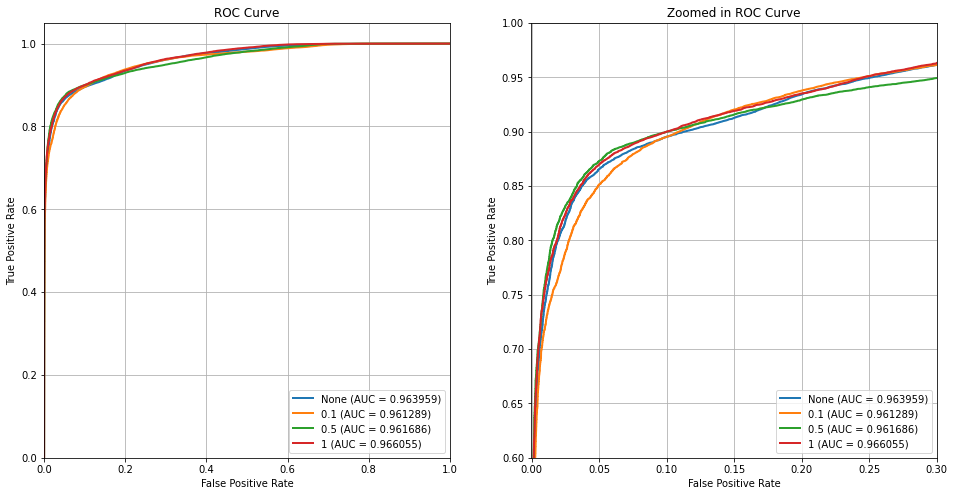

In [6]:
df, axs_test = report_alligned_metrics(base_fpr, tprs_mean, None, metrics)
df

c:\Users\dtrizna\Code\nebula\evaluation\crossValidation\Transformer_Engineering\grad_clip_limit_None_1677328633\../../../..\nebula\misc\plots.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + list(np.arange(start, len(loss_mean)*n, len(loss_mean)*n//xticks)))


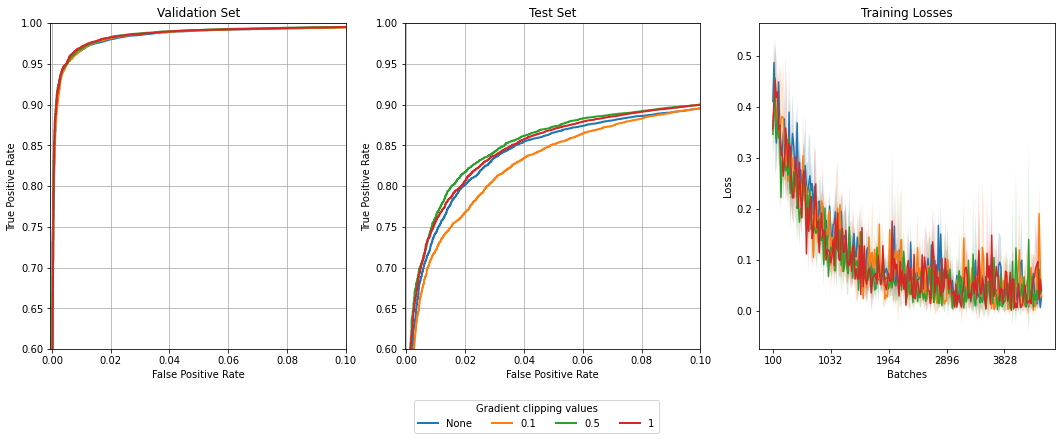

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 0.01:
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], model_name=key, ax=axs[0], ylim=[0.6,1], xlim=[-0.0005, 0.1])
    plot_roc_curve(base_fpr, tprs_mean[key], model_name=key, ax=axs[1], ylim=[0.6,1], xlim=[-0.0005, 0.1])

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

plot_losses(RUN_TYPES, ax=axs[2], skip_types=[])
#axs[2].legend(loc='upper right', title="Learning rate")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title=RUN_NAME.capitalize(), bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')